# Flat Image Net - Evaluate Results

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [4]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')

    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
        raw_prediction = tf.nn.dropout(raw_prediction, keep_dropout_prob)
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [5]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'

logging_meta = init_model_logging(base_dir, 'experiment_model_eval', graph=graph, remove_existing=True)

## Run Net

In [6]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']
        
with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(10000):
        ##################
        # Training phase #
        ##################
        _images, _labels = data.train.next_batch(100)
        _ = session.run([train_step], feed_dict={images: _images, labels: _labels, keep_dropout_prob: 0.5})
        if iteration % 10 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss],
                                                     feed_dict={images: _images, 
                                                                labels: _labels, 
                                                                keep_dropout_prob: 1.0})
            logging_meta['train_writer'].add_summary(_summary, iteration)
            print("Train Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
      
        ####################
        # Validation phase #
        ####################
        if iteration % 100 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss], 
                                          feed_dict={images: data.validation.images, 
                                                     labels: data.validation.labels,
                                                     keep_dropout_prob: 1.0})
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("= Valid Iteration {}: loss {}, accuracy {} =".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict={images: data.validation.images, keep_dropout_prob: 1.0})

Train Iteration 0: loss 2.267970323562622, accuracy 0.23000000417232513
= Valid Iteration 0: loss 2.273916482925415, accuracy 0.2231999933719635 =
Train Iteration 10: loss 2.153895139694214, accuracy 0.5600000023841858
Train Iteration 20: loss 1.9925929307937622, accuracy 0.6600000262260437
Train Iteration 30: loss 1.9587221145629883, accuracy 0.6700000166893005
Train Iteration 40: loss 1.9472723007202148, accuracy 0.6899999976158142
Train Iteration 50: loss 1.8663333654403687, accuracy 0.75
Train Iteration 60: loss 1.881197214126587, accuracy 0.699999988079071
Train Iteration 70: loss 1.8316165208816528, accuracy 0.75
Train Iteration 80: loss 1.8329005241394043, accuracy 0.7799999713897705
Train Iteration 90: loss 1.803199291229248, accuracy 0.8100000023841858
Train Iteration 100: loss 1.8031284809112549, accuracy 0.7900000214576721
= Valid Iteration 100: loss 1.8003236055374146, accuracy 0.7603999972343445 =
Train Iteration 110: loss 1.8061398267745972, accuracy 0.7200000286102295
Tr

Train Iteration 1100: loss 1.6420273780822754, accuracy 0.8299999833106995
= Valid Iteration 1100: loss 1.6385468244552612, accuracy 0.8406000137329102 =
Train Iteration 1110: loss 1.6368460655212402, accuracy 0.8600000143051147
Train Iteration 1120: loss 1.6791998147964478, accuracy 0.7699999809265137
Train Iteration 1130: loss 1.637022852897644, accuracy 0.8600000143051147
Train Iteration 1140: loss 1.6202800273895264, accuracy 0.8799999952316284
Train Iteration 1150: loss 1.6583410501480103, accuracy 0.8199999928474426
Train Iteration 1160: loss 1.6570863723754883, accuracy 0.8500000238418579
Train Iteration 1170: loss 1.6507165431976318, accuracy 0.8199999928474426
Train Iteration 1180: loss 1.6725293397903442, accuracy 0.800000011920929
Train Iteration 1190: loss 1.670074462890625, accuracy 0.8199999928474426
Train Iteration 1200: loss 1.649946689605713, accuracy 0.8399999737739563
= Valid Iteration 1200: loss 1.6318227052688599, accuracy 0.847000002861023 =
Train Iteration 1210: 

Train Iteration 2190: loss 1.5572857856750488, accuracy 0.9300000071525574
Train Iteration 2200: loss 1.662811279296875, accuracy 0.8199999928474426
= Valid Iteration 2200: loss 1.6196216344833374, accuracy 0.8519999980926514 =
Train Iteration 2210: loss 1.6495083570480347, accuracy 0.8100000023841858
Train Iteration 2220: loss 1.5916861295700073, accuracy 0.8700000047683716
Train Iteration 2230: loss 1.680516004562378, accuracy 0.7799999713897705
Train Iteration 2240: loss 1.598018765449524, accuracy 0.8500000238418579
Train Iteration 2250: loss 1.6382859945297241, accuracy 0.8399999737739563
Train Iteration 2260: loss 1.6520864963531494, accuracy 0.8100000023841858
Train Iteration 2270: loss 1.6416025161743164, accuracy 0.8299999833106995
Train Iteration 2280: loss 1.6512274742126465, accuracy 0.8399999737739563
Train Iteration 2290: loss 1.6269922256469727, accuracy 0.8700000047683716
Train Iteration 2300: loss 1.5879461765289307, accuracy 0.9100000262260437
= Valid Iteration 2300: 

= Valid Iteration 3200: loss 1.6169214248657227, accuracy 0.8510000109672546 =
Train Iteration 3210: loss 1.6658196449279785, accuracy 0.7900000214576721
Train Iteration 3220: loss 1.6252604722976685, accuracy 0.8500000238418579
Train Iteration 3230: loss 1.6278588771820068, accuracy 0.8299999833106995
Train Iteration 3240: loss 1.5904722213745117, accuracy 0.8700000047683716
Train Iteration 3250: loss 1.628546118736267, accuracy 0.8500000238418579
Train Iteration 3260: loss 1.6431303024291992, accuracy 0.8299999833106995
Train Iteration 3270: loss 1.5853261947631836, accuracy 0.8700000047683716
Train Iteration 3280: loss 1.5956040620803833, accuracy 0.8899999856948853
Train Iteration 3290: loss 1.5812327861785889, accuracy 0.8899999856948853
Train Iteration 3300: loss 1.6355944871902466, accuracy 0.8299999833106995
= Valid Iteration 3300: loss 1.627691388130188, accuracy 0.8396000266075134 =
Train Iteration 3310: loss 1.56856107711792, accuracy 0.9200000166893005
Train Iteration 3320:

Train Iteration 4290: loss 1.5848618745803833, accuracy 0.8799999952316284
Train Iteration 4300: loss 1.5767689943313599, accuracy 0.8899999856948853
= Valid Iteration 4300: loss 1.6017799377441406, accuracy 0.8672000169754028 =
Train Iteration 4310: loss 1.6125346422195435, accuracy 0.8600000143051147
Train Iteration 4320: loss 1.5955244302749634, accuracy 0.8600000143051147
Train Iteration 4330: loss 1.6102215051651, accuracy 0.8500000238418579
Train Iteration 4340: loss 1.5551143884658813, accuracy 0.9200000166893005
Train Iteration 4350: loss 1.6439330577850342, accuracy 0.8299999833106995
Train Iteration 4360: loss 1.5799307823181152, accuracy 0.8799999952316284
Train Iteration 4370: loss 1.611329197883606, accuracy 0.8600000143051147
Train Iteration 4380: loss 1.5609005689620972, accuracy 0.9100000262260437
Train Iteration 4390: loss 1.626826524734497, accuracy 0.8299999833106995
Train Iteration 4400: loss 1.575799822807312, accuracy 0.8899999856948853
= Valid Iteration 4400: los

Train Iteration 5320: loss 1.6071010828018188, accuracy 0.8600000143051147
Train Iteration 5330: loss 1.578526258468628, accuracy 0.8999999761581421
Train Iteration 5340: loss 1.5962485074996948, accuracy 0.8700000047683716
Train Iteration 5350: loss 1.6591522693634033, accuracy 0.8100000023841858
Train Iteration 5360: loss 1.551220417022705, accuracy 0.9200000166893005
Train Iteration 5370: loss 1.5843204259872437, accuracy 0.8899999856948853
Train Iteration 5380: loss 1.58171808719635, accuracy 0.8799999952316284
Train Iteration 5390: loss 1.5784096717834473, accuracy 0.8899999856948853
Train Iteration 5400: loss 1.569672703742981, accuracy 0.8799999952316284
= Valid Iteration 5400: loss 1.5922460556030273, accuracy 0.8730000257492065 =
Train Iteration 5410: loss 1.5654356479644775, accuracy 0.8999999761581421
Train Iteration 5420: loss 1.618119478225708, accuracy 0.8600000143051147
Train Iteration 5430: loss 1.567395806312561, accuracy 0.9100000262260437
Train Iteration 5440: loss 1

Train Iteration 6420: loss 1.543614149093628, accuracy 0.9200000166893005
Train Iteration 6430: loss 1.6573209762573242, accuracy 0.8199999928474426
Train Iteration 6440: loss 1.6182758808135986, accuracy 0.8500000238418579
Train Iteration 6450: loss 1.6442248821258545, accuracy 0.8199999928474426
Train Iteration 6460: loss 1.5488471984863281, accuracy 0.8999999761581421
Train Iteration 6470: loss 1.5968222618103027, accuracy 0.8799999952316284
Train Iteration 6480: loss 1.6470261812210083, accuracy 0.8100000023841858
Train Iteration 6490: loss 1.6298446655273438, accuracy 0.8399999737739563
Train Iteration 6500: loss 1.5947365760803223, accuracy 0.8799999952316284
= Valid Iteration 6500: loss 1.5956768989562988, accuracy 0.8691999912261963 =
Train Iteration 6510: loss 1.6516015529632568, accuracy 0.7900000214576721
Train Iteration 6520: loss 1.6256933212280273, accuracy 0.8500000238418579
Train Iteration 6530: loss 1.5689520835876465, accuracy 0.8999999761581421
Train Iteration 6540: 

Train Iteration 7500: loss 1.5336554050445557, accuracy 0.949999988079071
= Valid Iteration 7500: loss 1.590357780456543, accuracy 0.8727999925613403 =
Train Iteration 7510: loss 1.5878801345825195, accuracy 0.8799999952316284
Train Iteration 7520: loss 1.598565936088562, accuracy 0.8799999952316284
Train Iteration 7530: loss 1.621841549873352, accuracy 0.8299999833106995
Train Iteration 7540: loss 1.5586235523223877, accuracy 0.8999999761581421
Train Iteration 7550: loss 1.5445483922958374, accuracy 0.9300000071525574
Train Iteration 7560: loss 1.5514532327651978, accuracy 0.9200000166893005
Train Iteration 7570: loss 1.6965900659561157, accuracy 0.75
Train Iteration 7580: loss 1.5481410026550293, accuracy 0.9300000071525574
Train Iteration 7590: loss 1.6000876426696777, accuracy 0.8500000238418579
Train Iteration 7600: loss 1.6527234315872192, accuracy 0.8100000023841858
= Valid Iteration 7600: loss 1.5964634418487549, accuracy 0.8646000027656555 =
Train Iteration 7610: loss 1.627602

= Valid Iteration 8500: loss 1.588779091835022, accuracy 0.8758000135421753 =
Train Iteration 8510: loss 1.5762945413589478, accuracy 0.8999999761581421
Train Iteration 8520: loss 1.6061373949050903, accuracy 0.8399999737739563
Train Iteration 8530: loss 1.6337857246398926, accuracy 0.8299999833106995
Train Iteration 8540: loss 1.5996781587600708, accuracy 0.8600000143051147
Train Iteration 8550: loss 1.6161428689956665, accuracy 0.8500000238418579
Train Iteration 8560: loss 1.6536613702774048, accuracy 0.8100000023841858
Train Iteration 8570: loss 1.6207064390182495, accuracy 0.8399999737739563
Train Iteration 8580: loss 1.6014671325683594, accuracy 0.8600000143051147
Train Iteration 8590: loss 1.605079174041748, accuracy 0.8600000143051147
Train Iteration 8600: loss 1.6133090257644653, accuracy 0.8600000143051147
= Valid Iteration 8600: loss 1.587275743484497, accuracy 0.8777999877929688 =
Train Iteration 8610: loss 1.6479804515838623, accuracy 0.8100000023841858
Train Iteration 8620

Train Iteration 9560: loss 1.5863488912582397, accuracy 0.8799999952316284
Train Iteration 9570: loss 1.5701311826705933, accuracy 0.9100000262260437
Train Iteration 9580: loss 1.5599031448364258, accuracy 0.9100000262260437
Train Iteration 9590: loss 1.5910142660140991, accuracy 0.8700000047683716
Train Iteration 9600: loss 1.5540167093276978, accuracy 0.9100000262260437
= Valid Iteration 9600: loss 1.5839359760284424, accuracy 0.8790000081062317 =
Train Iteration 9610: loss 1.5566151142120361, accuracy 0.8999999761581421
Train Iteration 9620: loss 1.5543802976608276, accuracy 0.9100000262260437
Train Iteration 9630: loss 1.5552012920379639, accuracy 0.9100000262260437
Train Iteration 9640: loss 1.6354161500930786, accuracy 0.8100000023841858
Train Iteration 9650: loss 1.578274130821228, accuracy 0.8799999952316284
Train Iteration 9660: loss 1.612459659576416, accuracy 0.8399999737739563
Train Iteration 9670: loss 1.5817832946777344, accuracy 0.8999999761581421
Train Iteration 9680: l

In [7]:
_prediction

array([[  7.26473424e-16,   4.42368378e-15,   1.43633379e-17, ...,
          2.71886194e-08,   5.89126109e-11,   1.00000000e+00],
       [  1.00000000e+00,   8.89158332e-21,   5.55745224e-18, ...,
          4.61611160e-22,   4.55494863e-19,   7.98971041e-17],
       [  9.79118526e-01,   1.40857510e-03,   4.08285967e-04, ...,
          2.71938291e-07,   2.62772892e-06,   5.72504177e-05],
       ..., 
       [  2.16707818e-07,   8.04376228e-08,   1.84388909e-07, ...,
          6.15131401e-04,   1.85806668e-04,   1.46426784e-04],
       [  2.28083497e-10,   1.84060892e-10,   3.41890916e-09, ...,
          1.25754482e-13,   9.99999881e-01,   2.40164948e-15],
       [  1.77662344e-06,   4.15759685e-04,   1.95424104e-06, ...,
          2.27859545e-07,   5.26815484e-06,   4.26028273e-05]], dtype=float32)

## Load reuslts to pandas df

In [8]:
from utils.results_evaluation import get_info_df

df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, images=data.validation.images)
df

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ankle boot,1.000000,Ankle boot,Ankle boot,1.000000,1.000000
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0...",T-shirt/top,1.000000,T-shirt/top,T-shirt/top,1.000000,1.000000
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.979119,T-shirt/top,T-shirt/top,0.979119,0.979119
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",Dress,0.101438,Shirt,Dress,0.710760,0.101438
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.059319,Dress,T-shirt/top,0.930382,0.059319
5,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Pullover,1.000000,Pullover,Pullover,1.000000,1.000000
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sneaker,0.999987,Sneaker,Sneaker,0.999987,0.999987
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.003921...",Pullover,0.922720,Pullover,Pullover,0.922720,0.922720
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000


In [9]:
df.columns

Index(['image', 'label_class_name', 'label_class_score',
       'predicted_class_name_top1', 'predicted_class_name_top3',
       'predicted_class_score_top1', 'predicted_class_score_top3'],
      dtype='object')

## Precision

In [10]:
def get_precision(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    positives = len(df[(df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)

In [11]:
get_precision(df, 'T-shirt/top')

71.33

## Recall

In [12]:
def get_recall(df, class_name):
    ###################
    # Complete recall #
    ###################
    return 0

In [13]:
get_recall(df, 'T-shirt/top')

0

## Accuracy

In [14]:
def get_accuracy(df):
    #####################
    # Complete accuracy #
    #####################
    return 0

In [15]:
get_accuracy(df)

0

## Overall Recall and Precision

In [16]:
def get_rec_prec(df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [17]:
get_rec_prec(df, class_id2class_name_mapping).sort_values(by='recall')

,class_name,precision,recall
0,T-shirt/top,71.33,0
1,Trouser,98.91,0
2,Pullover,78.56,0
3,Dress,93.29,0
4,Coat,71.02,0
5,Sandal,97.89,0
6,Shirt,85.45,0
7,Sneaker,92.05,0
8,Bag,93.05,0
9,Ankle boot,94.90,0


## False Positives

In [18]:
def get_false_positives(df, label_class_name, predicted_class_name=None):
    condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    ####################################################
    # Specify false positives for certain target class #
    ####################################################
    return df[condition].sort_values(by='predicted_class_score_top1', ascending=False)



In [19]:
fp = get_false_positives(df, 'Shirt')
fp

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.947914e-08,T-shirt/top,Shirt,1.000000,1.947914e-08
3533,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035...",Shirt,8.680011e-10,T-shirt/top,Shirt,1.000000,8.680011e-10
3298,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.612815e-09,T-shirt/top,Shirt,1.000000,1.612815e-09
3270,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.684291e-08,T-shirt/top,Shirt,1.000000,1.684291e-08
1119,"[0.0, 0.0, 0.0, 0.0, 0.0235294, 0.0156863, 0.0...",Shirt,4.668403e-08,T-shirt/top,Shirt,1.000000,4.668403e-08
3946,"[0.0, 0.0, 0.00784314, 0.00392157, 0.00392157,...",Shirt,3.720280e-11,T-shirt/top,Shirt,1.000000,3.720280e-11
3087,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.207843, 0.498...",Shirt,1.254230e-13,T-shirt/top,Shirt,1.000000,1.254230e-13
1388,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.313726, 0.690...",Shirt,6.998508e-09,T-shirt/top,Shirt,1.000000,6.998508e-09
502,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0...",Shirt,2.545924e-12,Coat,Pullover,1.000000,5.298109e-09
4031,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.315484e-10,T-shirt/top,Shirt,1.000000,1.315484e-10


In [20]:
def plot_examples(df, img_shape=(28, 28)):
    examples_count = min(25, len(df))
    cols = 5
    rows = np.ceil(examples_count / cols)
    
    fig = plt.figure(figsize=(20,25))
    for img_id in range(examples_count):
        ax = plt.subplot(rows, cols, img_id+1)

        img = df.image.iloc[img_id]
        if img is None:
            continue
        img = img.reshape(img_shape)
        prediction_name = df.predicted_class_name_top1.iloc[img_id]
        prediction_score = df.predicted_class_score_top1.iloc[img_id]

        ax.imshow(img , cmap='gray')
        ax.set_title("{0}: {1}".format(prediction_name, round(prediction_score, 2)))
        ax.axes.set_axis_off()

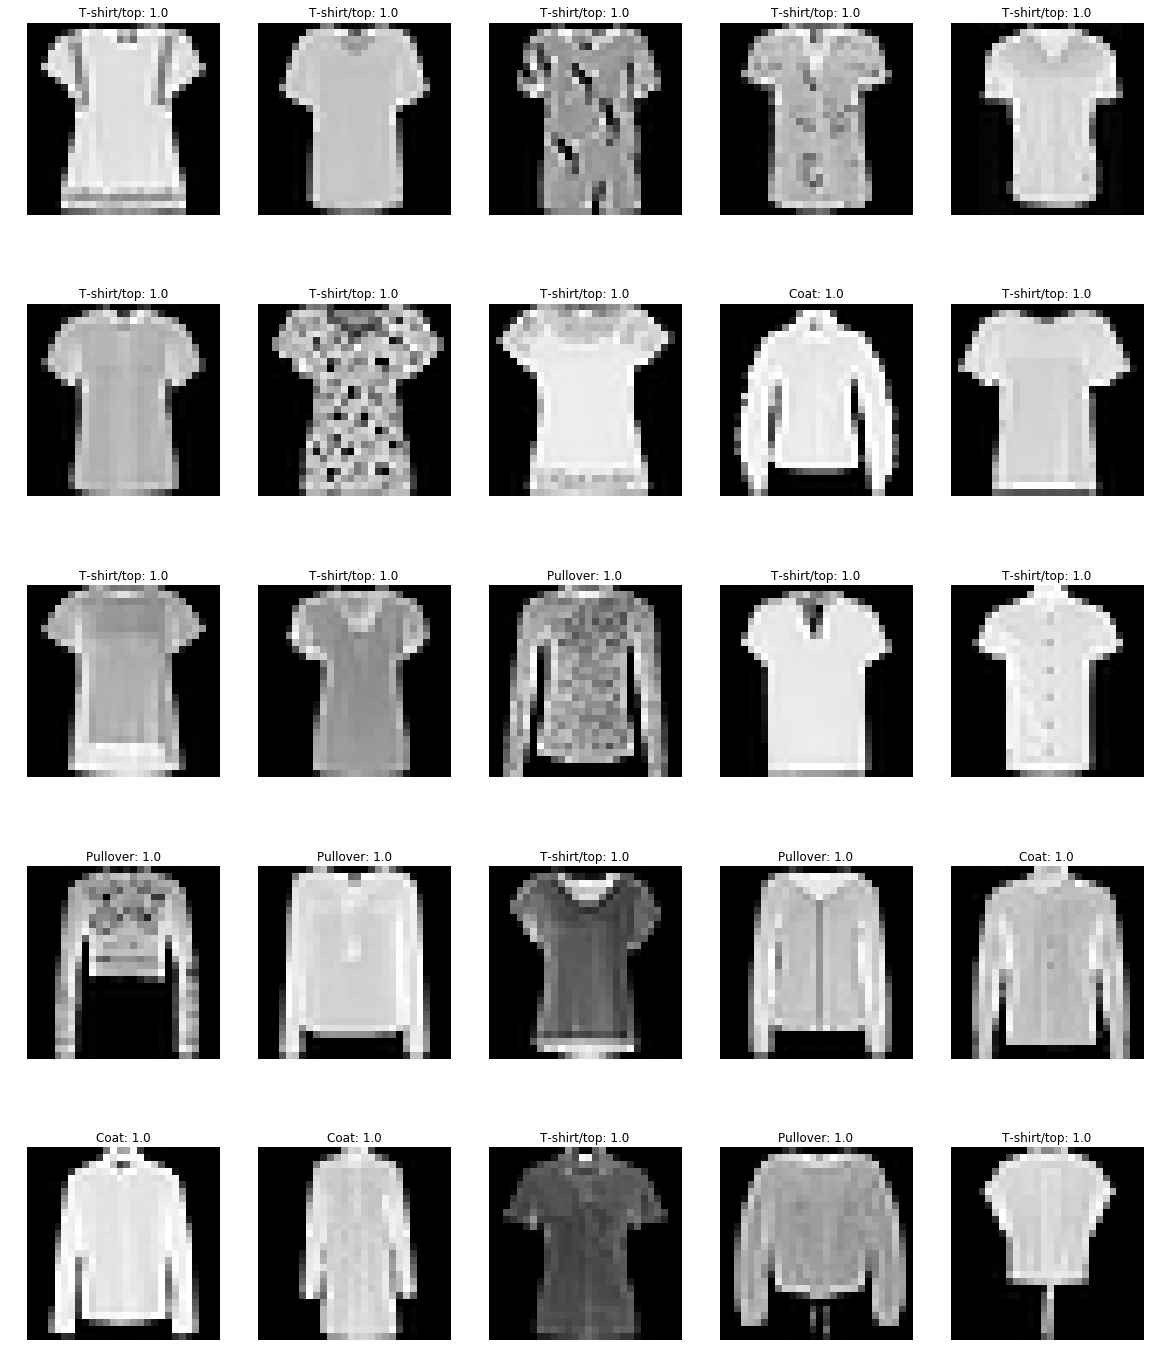

In [21]:
plot_examples(fp)

## Coocurance matrix

In [25]:
def plot_coocurance_matrix(df, use_log=False, use_top3=False):
    if use_top3:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top3']
    else:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top1']
    coocurance_df = pd.pivot_table(df[coocurance_cols], index=coocurance_cols[0], 
                                   columns=coocurance_cols[1], aggfunc=len, fill_value=0)
    if use_log:
        coocurance_df = np.log(coocurance_df)
        coocurance_df = coocurance_df.replace([-np.inf], 0)

    coocurance_df = coocurance_df.div(coocurance_df.sum(axis=1), axis=0) * 100
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    sns.heatmap(coocurance_df, ax=ax, annot=True,  linewidths=.5, 
                cbar_kws={"orientation": "horizontal"}, cmap="YlGnBu")

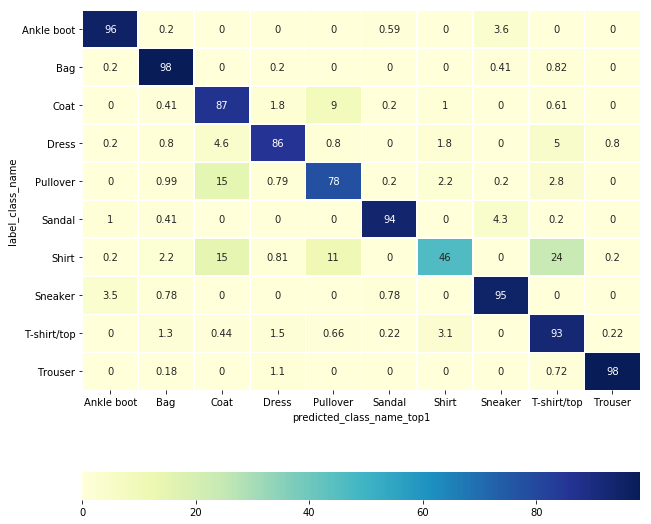

In [26]:
plot_coocurance_matrix(df, use_log=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


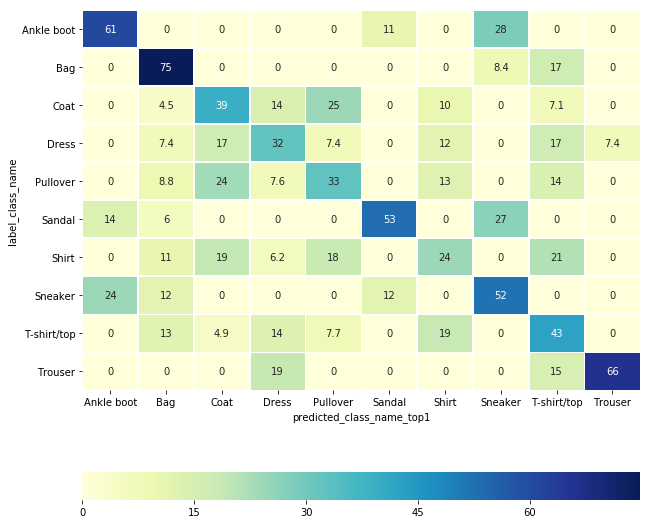

In [27]:
plot_coocurance_matrix(df, use_log=True)